## The Algorithms:
Exact: We use text[i:i+m] == pattern. In Python, this slicing operation is implemented in C and is incredibly fast (often matching or beating a manual KMP implementation in raw Python).

Fuzzy: We perform a localized Levenshtein check only at that specific window.

In [4]:
import sys
import os
from Bio import SeqIO
from Bio import SearchIO # For parsing GFF

# --- 1. PRE-PROCESSING: The Map Builder ---

def build_structure_mask(genome_length, gff_filepath):
    """
    Creates a boolean array (mask) where:
    True  = Coding Region (CDS) -> Strict Matching
    False = Non-Coding Region   -> Fuzzy Matching
    """
    print(f"Building Structure Mask from {gff_filepath}...")
    
    # Initialize a boolean array of False (default to Non-Coding/Fuzzy)
    # bytearray is memory efficient (1 byte per base)
    is_coding_mask = bytearray(genome_length) 
    
    try:
        # Parse the GFF file
        # Note: Biopython's GFF parser can be tricky depending on version.
        # We will use a manual reader for robustness with standard NCBI GFF3.
        with open(gff_filepath, 'r') as f:
            for line in f:
                if line.startswith("#"): continue
                parts = line.strip().split('\t')
                if len(parts) < 9: continue
                
                feature_type = parts[2]
                start = int(parts[3]) - 1 # GFF is 1-based, Python is 0-based
                end = int(parts[4])       # End is inclusive in GFF
                
                # If it is a Coding Sequence (CDS), mark this region as True (1)
                if feature_type == "CDS":
                    # Set the range in the mask to 1
                    for i in range(start, end):
                        if i < genome_length:
                            is_coding_mask[i] = 1
                            
    except Exception as e:
        print(f"Error parsing GFF: {e}")
        return None
        
    count_coding = is_coding_mask.count(1)
    print(f"Map built. Coding: {count_coding} bp, Non-Coding: {genome_length - count_coding} bp")
    return is_coding_mask


# --- 2. ALGORITHMS: The Strategies ---

def is_exact_match(text, pattern, start_index):
    """
    Checks for an EXACT match starting at start_index.
    Uses Python's highly optimized slice comparison (functionally similar to KMP).
    """
    # This compares the slice. It is O(m) but extremely optimized in C.
    return text[start_index : start_index + len(pattern)] == pattern

def is_fuzzy_match(text, pattern, start_index, k):
    """
    Checks for a FUZZY match starting at start_index using Levenshtein logic.
    This is a localized check, not a global search.
    """
    n = len(pattern)
    m = len(pattern) # We look at a window roughly the size of the pattern
    
    # Optimization: Don't run full DP if the slice is obviously different.
    # Just grab the window from the text
    text_window = text[start_index : start_index + m + k] # Grab a bit extra for indels
    
    # Quick check: if lengths don't allow a match, return False
    if len(text_window) < m - k:
        return False

    # Run bounded Levenshtein calculation for this small window
    # (Simplified DP for just two strings)
    # If you have the 'Levenshtein' C-library installed, use `Levenshtein.distance()`
    # Here is a pure python implementation for the window:
    
    # DP initialization
    previous_row = range(len(text_window) + 1)
    for i, c1 in enumerate(pattern):
        current_row = [i + 1]
        for j, c2 in enumerate(text_window):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    # Check if the distance is within k
    return previous_row[-1] <= k


# --- 3. THE ENGINE: Structure-Aware Hybrid Search ---

def structure_aware_search(genome_filepath, gff_filepath, pattern, k=1):
    
    # A. Load Genome
    print(f"Loading genome from {genome_filepath}...")
    genome_record = SeqIO.read(genome_filepath, "fasta")
    genome_text = str(genome_record.seq).upper()
    genome_len = len(genome_text)
    
    # B. Build the Map (Pre-processing)
    mask = build_structure_mask(genome_len, gff_filepath)
    if mask is None: return
    
    matches = []
    m = len(pattern)
    
    print(f"\nStarting Hybrid Search for '{pattern}'...")
    print("Strategy: Exact Match in CDS (Exons), Fuzzy Match in Non-Coding.")
    
    # C. The Contextual Switching Loop
    for i in range(genome_len - m + 1):
        
        # --- THE SWITCH ---
        # Check the mask at the current index
        is_coding_region = mask[i]
        
        if is_coding_region:
            # CONTEXT: Coding Region (CDS)
            # ACTION: Strict, Exact Search
            if is_exact_match(genome_text, pattern, i):
                matches.append((i, "Exact (CDS)"))
                
        else:
            # CONTEXT: Non-Coding Region
            # ACTION: Flexible, Fuzzy Search
            # Note: We only run this if exact match fails (or strictly instead of exact)
            # Usually, you check exact first anyway for speed, but here we enforce the logic:
            if is_fuzzy_match(genome_text, pattern, i, k):
                # We double check if it was actually exact to label it correctly
                lbl = "Exact (Non-Coding)" if genome_text[i:i+m] == pattern else f"Fuzzy (Non-Coding)"
                matches.append((i, lbl))
                
        # Progress indicator (optional)
        if i % 500000 == 0:
            print(f"Scanned {i}/{genome_len} bp...")

    return matches

# --- 4. EXECUTION ---

if __name__ == "__main__":
    # File Setup
    fna_file = "GCF_025643435.1/GCF_025643435.1_ASM2564343v1_genomic.fna"
    gff_file = "GCF_025643435.1/genomic.gff"
    
    # Search Parameters
    search_pattern = "TATAAT"
    k_threshold = 1
    
    if os.path.exists(fna_file) and os.path.exists(gff_file):
        results = structure_aware_search(fna_file, gff_file, search_pattern, k_threshold)
        
        print(f"\n--- Results ---")
        print(f"Total Matches: {len(results)}")
        print("First 10 matches:")
        for idx, region_type in results[:10]:
            print(f"  Pos: {idx:<10} Type: {region_type}")
    else:
        print("Error: Please ensure both .fna and .gff files are present.")
        print(f"Looking for:\n  - {fna_file}\n  - {gff_file}")

Loading genome from GCF_025643435.1/GCF_025643435.1_ASM2564343v1_genomic.fna...
Building Structure Mask from GCF_025643435.1/genomic.gff...
Map built. Coding: 4121071 bp, Non-Coding: 554117 bp

Starting Hybrid Search for 'TATAAT'...
Strategy: Exact Match in CDS (Exons), Fuzzy Match in Non-Coding.
Scanned 0/4675188 bp...
Scanned 500000/4675188 bp...
Scanned 1000000/4675188 bp...
Scanned 1500000/4675188 bp...
Scanned 2000000/4675188 bp...
Scanned 2500000/4675188 bp...
Scanned 3000000/4675188 bp...
Scanned 3500000/4675188 bp...
Scanned 4000000/4675188 bp...
Scanned 4500000/4675188 bp...

--- Results ---
Total Matches: 1791
First 10 matches:
  Pos: 3588       Type: Fuzzy (Non-Coding)
  Pos: 8443       Type: Fuzzy (Non-Coding)
  Pos: 17369      Type: Fuzzy (Non-Coding)
  Pos: 21738      Type: Exact (CDS)
  Pos: 23177      Type: Exact (CDS)
  Pos: 30416      Type: Fuzzy (Non-Coding)
  Pos: 30703      Type: Fuzzy (Non-Coding)
  Pos: 39669      Type: Exact (CDS)
  Pos: 39785      Type: Fuzzy (

## Performance Analysis: Time & Memory Benchmarking

This section analyzes the time and memory performance of the structure-aware hybrid search across different genome sizes and pattern configurations.

In [5]:
import timeit
import tracemalloc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def benchmark_hybrid_search(fna_file, gff_file, pattern, k, slice_sizes):
    """
    Benchmark the hybrid search across different genome slice sizes.
    Returns a DataFrame with timing and memory metrics.
    """
    results = []
    
    # Load full genome once
    print(f"Loading full genome from {fna_file}...")
    genome_record = SeqIO.read(fna_file, "fasta")
    full_genome = str(genome_record.seq).upper()
    genome_len = len(full_genome)
    
    # Build mask once for full genome
    print(f"Building structure mask...")
    full_mask = build_structure_mask(genome_len, gff_file)
    if full_mask is None:
        print("Failed to build mask")
        return pd.DataFrame()
    
    for slice_size in slice_sizes:
        print(f"\n--- Benchmarking slice size: {slice_size:,} bp ---")
        
        if slice_size > genome_len:
            print(f"Slice size {slice_size} exceeds genome length {genome_len}. Skipping.")
            continue
        
        # Slice the genome and mask
        genome_slice = full_genome[:slice_size]
        mask_slice = full_mask[:slice_size]
        
        # Define the search function for this slice
        def search_slice():
            matches = []
            m = len(pattern)
            for i in range(len(genome_slice) - m + 1):
                is_coding_region = mask_slice[i]
                if is_coding_region:
                    if is_exact_match(genome_slice, pattern, i):
                        matches.append((i, "Exact (CDS)"))
                else:
                    if is_fuzzy_match(genome_slice, pattern, i, k):
                        lbl = "Exact (Non-Coding)" if genome_slice[i:i+m] == pattern else f"Fuzzy (Non-Coding)"
                        matches.append((i, lbl))
            return matches
        
        # Time measurement
        print("Measuring time...")
        num_runs = max(3, 10 if slice_size <= 100000 else 3)
        timer = timeit.Timer(search_slice)
        total_time = timer.timeit(number=num_runs)
        avg_time = total_time / num_runs
        print(f"  Avg time: {avg_time:.4f} seconds ({num_runs} runs)")
        
        # Memory measurement
        print("Measuring memory...")
        tracemalloc.start()
        matches = search_slice()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        peak_mb = peak / (1024 ** 2)
        print(f"  Peak memory: {peak_mb:.2f} MB")
        print(f"  Matches found: {len(matches)}")
        
        # Count match types
        exact_cds = sum(1 for _, t in matches if t == "Exact (CDS)")
        exact_nc = sum(1 for _, t in matches if t == "Exact (Non-Coding)")
        fuzzy_nc = sum(1 for _, t in matches if t.startswith("Fuzzy"))
        
        results.append({
            "slice_size": slice_size,
            "avg_time_s": avg_time,
            "peak_memory_mb": peak_mb,
            "total_matches": len(matches),
            "exact_cds": exact_cds,
            "exact_noncoding": exact_nc,
            "fuzzy_noncoding": fuzzy_nc,
        })
    
    return pd.DataFrame(results)

# Run benchmark
print("\n" + "="*60)
print("PERFORMANCE BENCHMARKING")
print("="*60)

slice_sizes = [50000, 100000, 200000, 300000, 500000, 1000000]
benchmark_df = benchmark_hybrid_search(fna_file, gff_file, search_pattern, k_threshold, slice_sizes)

if not benchmark_df.empty:
    print("\n--- Benchmark Results ---")
    print(benchmark_df.to_string(index=False))
else:
    print("Benchmark failed to produce results.")


PERFORMANCE BENCHMARKING
Loading full genome from GCF_025643435.1/GCF_025643435.1_ASM2564343v1_genomic.fna...
Building structure mask...
Building Structure Mask from GCF_025643435.1/genomic.gff...
Map built. Coding: 4121071 bp, Non-Coding: 554117 bp

--- Benchmarking slice size: 50,000 bp ---
Measuring time...
  Avg time: 0.0662 seconds (10 runs)
Measuring memory...
  Peak memory: 0.00 MB
  Matches found: 13

--- Benchmarking slice size: 100,000 bp ---
Measuring time...
  Avg time: 0.1268 seconds (10 runs)
Measuring memory...
  Peak memory: 0.00 MB
  Matches found: 42

--- Benchmarking slice size: 200,000 bp ---
Measuring time...
  Avg time: 0.2806 seconds (3 runs)
Measuring memory...
  Peak memory: 0.00 MB
  Matches found: 79

--- Benchmarking slice size: 300,000 bp ---
Measuring time...
  Avg time: 0.4280 seconds (3 runs)
Measuring memory...
  Peak memory: 0.01 MB
  Matches found: 135

--- Benchmarking slice size: 500,000 bp ---
Measuring time...
  Avg time: 0.7002 seconds (3 runs)


### Visualization: Time & Memory Performance


Performance graph saved as 'hybrid_search_performance.png'


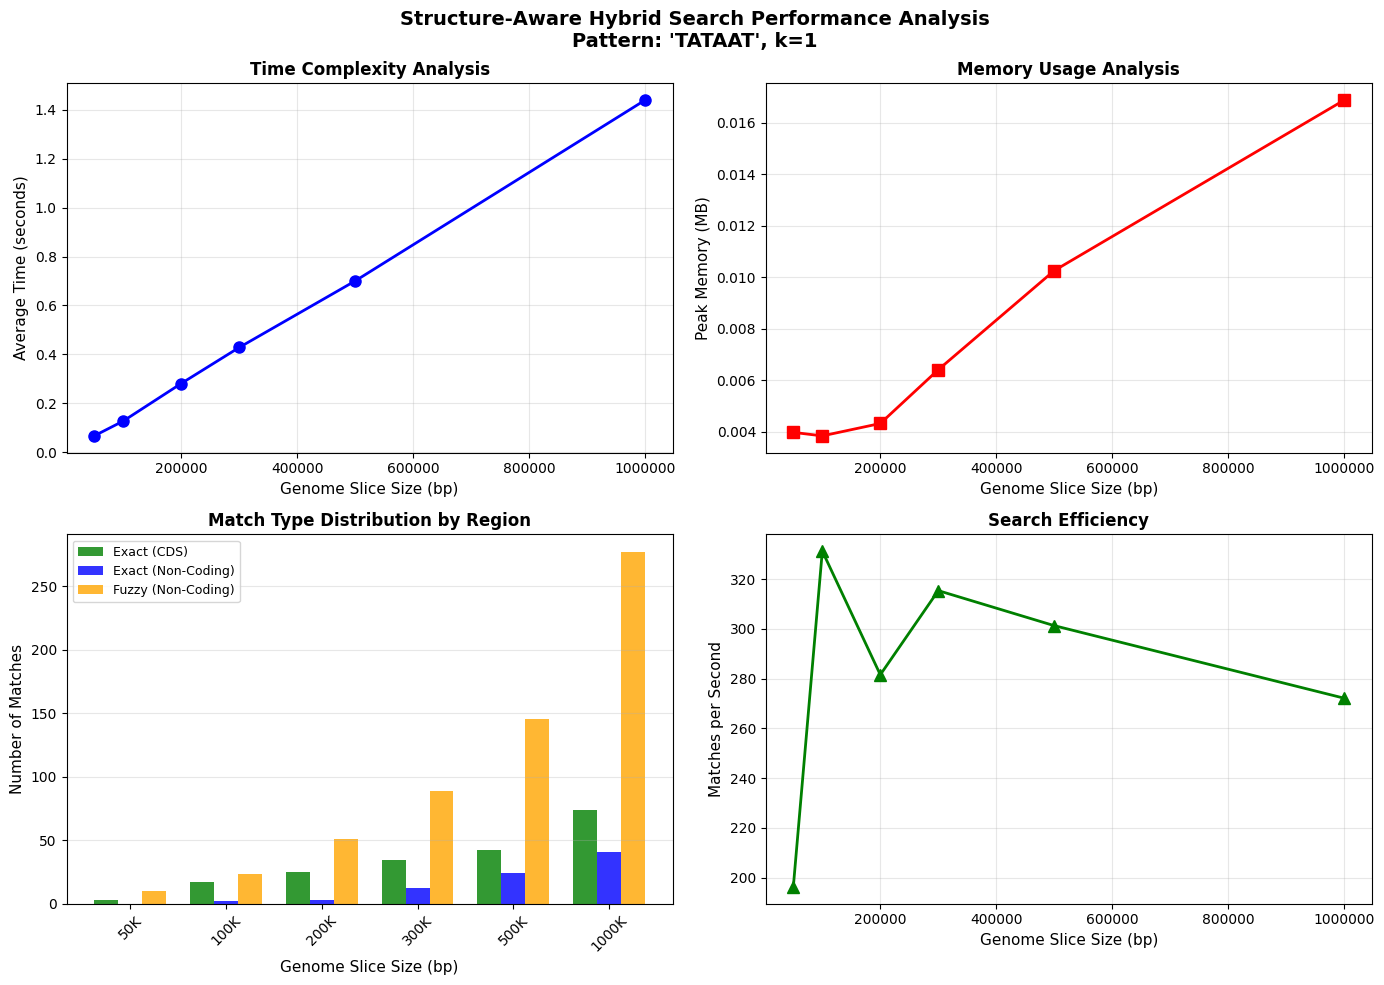

In [6]:
if not benchmark_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Structure-Aware Hybrid Search Performance Analysis\nPattern: '{search_pattern}', k={k_threshold}", 
                 fontsize=14, fontweight='bold')
    
    # Plot 1: Time vs Slice Size
    ax1 = axes[0, 0]
    ax1.plot(benchmark_df["slice_size"], benchmark_df["avg_time_s"], 'b-o', linewidth=2, markersize=8)
    ax1.set_xlabel("Genome Slice Size (bp)", fontsize=11)
    ax1.set_ylabel("Average Time (seconds)", fontsize=11)
    ax1.set_title("Time Complexity Analysis", fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.ticklabel_format(style='plain', axis='x')
    
    # Plot 2: Memory vs Slice Size
    ax2 = axes[0, 1]
    ax2.plot(benchmark_df["slice_size"], benchmark_df["peak_memory_mb"], 'r-s', linewidth=2, markersize=8)
    ax2.set_xlabel("Genome Slice Size (bp)", fontsize=11)
    ax2.set_ylabel("Peak Memory (MB)", fontsize=11)
    ax2.set_title("Memory Usage Analysis", fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.ticklabel_format(style='plain', axis='x')
    
    # Plot 3: Match Distribution
    ax3 = axes[1, 0]
    width = 0.25
    x = np.arange(len(benchmark_df))
    ax3.bar(x - width, benchmark_df["exact_cds"], width, label='Exact (CDS)', color='green', alpha=0.8)
    ax3.bar(x, benchmark_df["exact_noncoding"], width, label='Exact (Non-Coding)', color='blue', alpha=0.8)
    ax3.bar(x + width, benchmark_df["fuzzy_noncoding"], width, label='Fuzzy (Non-Coding)', color='orange', alpha=0.8)
    ax3.set_xlabel("Genome Slice Size (bp)", fontsize=11)
    ax3.set_ylabel("Number of Matches", fontsize=11)
    ax3.set_title("Match Type Distribution by Region", fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f"{int(s/1000)}K" for s in benchmark_df["slice_size"]], rotation=45)
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Efficiency Metric (Matches per Second)
    ax4 = axes[1, 1]
    efficiency = benchmark_df["total_matches"] / benchmark_df["avg_time_s"]
    ax4.plot(benchmark_df["slice_size"], efficiency, 'g-^', linewidth=2, markersize=8)
    ax4.set_xlabel("Genome Slice Size (bp)", fontsize=11)
    ax4.set_ylabel("Matches per Second", fontsize=11)
    ax4.set_title("Search Efficiency", fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.ticklabel_format(style='plain', axis='x')
    
    plt.tight_layout()
    plt.savefig("hybrid_search_performance.png", dpi=150, bbox_inches='tight')
    print("\nPerformance graph saved as 'hybrid_search_performance.png'")
    plt.show()
else:
    print("No benchmark data to plot.")

## Match Location Map

Visualize where matches occur across the genome, showing the distribution of exact vs fuzzy matches in coding vs non-coding regions.


GENERATING MATCH LOCATION MAP
Analyzing first 500,000 bp of genome...
Building Structure Mask from GCF_025643435.1/genomic.gff...
Map built. Coding: 4121071 bp, Non-Coding: 554117 bp
Searching for pattern 'TATAAT' with k=1...
Found 211 matches in 500,000 bp
Found 211 matches in 500,000 bp

Location map saved as 'hybrid_search_location_map.png'

Location map saved as 'hybrid_search_location_map.png'


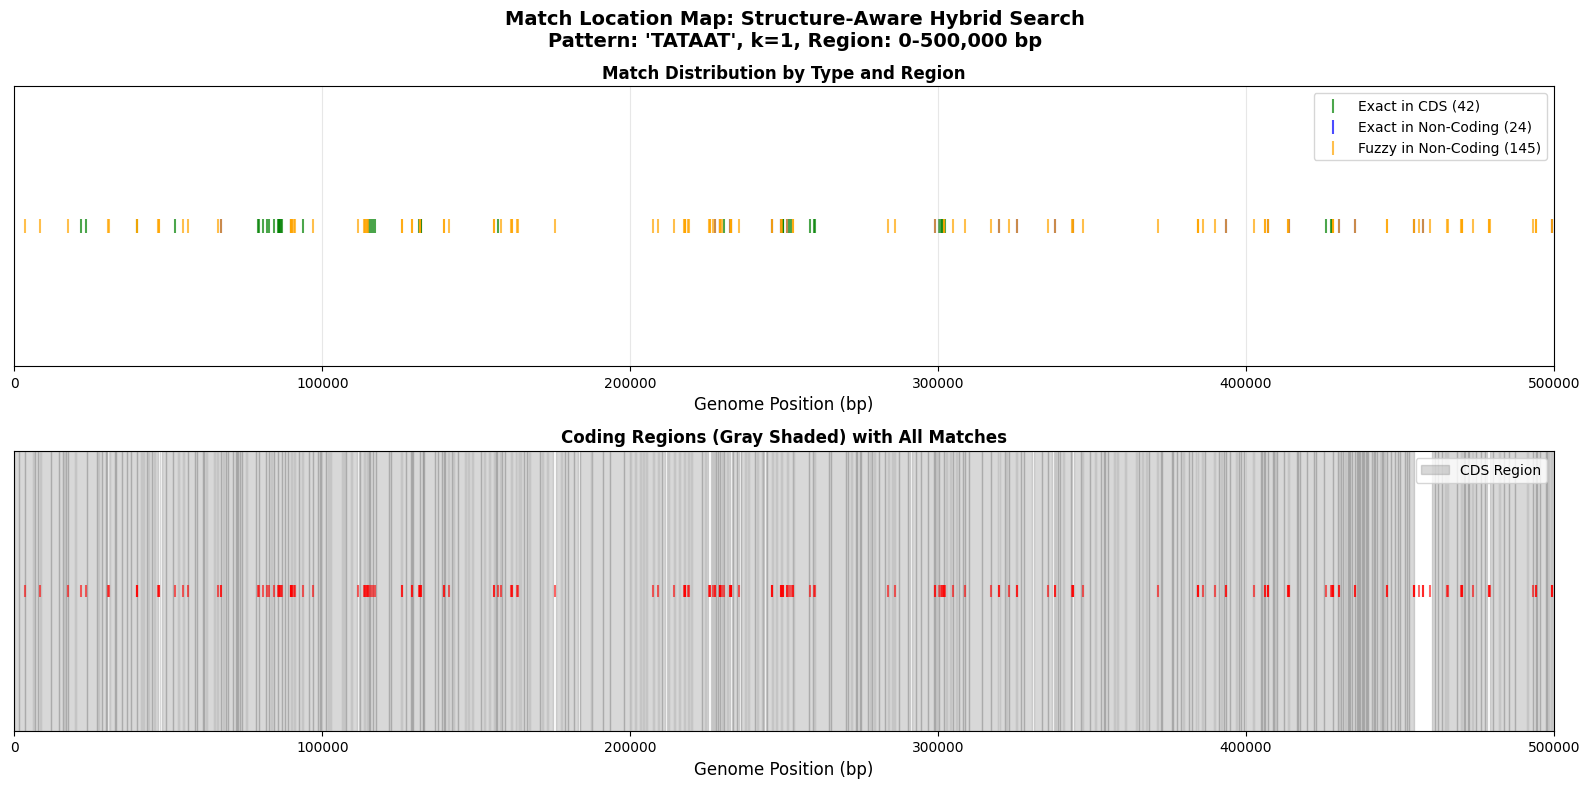


--- Match Distribution Summary ---
Exact matches in CDS:           42
Exact matches in Non-Coding:     24
Fuzzy matches in Non-Coding:    145
Total matches:                  211

Coding region coverage: 88.42%


In [7]:
# Generate location map for a manageable genome slice
MAP_SLICE_SIZE = 500000  # Use 500K bp for visualization

print(f"\n{'='*60}")
print("GENERATING MATCH LOCATION MAP")
print(f"{'='*60}")
print(f"Analyzing first {MAP_SLICE_SIZE:,} bp of genome...")

# Run search on slice for location mapping
if os.path.exists(fna_file) and os.path.exists(gff_file):
    # Load and slice genome
    genome_record = SeqIO.read(fna_file, "fasta")
    genome_text = str(genome_record.seq).upper()[:MAP_SLICE_SIZE]
    genome_len = len(genome_text)
    
    # Build mask for this slice
    full_mask = build_structure_mask(len(str(genome_record.seq)), gff_file)
    if full_mask:
        mask_slice = full_mask[:MAP_SLICE_SIZE]
        
        # Run hybrid search
        map_matches = []
        m = len(search_pattern)
        print(f"Searching for pattern '{search_pattern}' with k={k_threshold}...")
        
        for i in range(genome_len - m + 1):
            is_coding_region = mask_slice[i]
            
            if is_coding_region:
                if is_exact_match(genome_text, search_pattern, i):
                    map_matches.append((i, "Exact (CDS)"))
            else:
                if is_fuzzy_match(genome_text, search_pattern, i, k_threshold):
                    lbl = "Exact (Non-Coding)" if genome_text[i:i+m] == search_pattern else f"Fuzzy (Non-Coding)"
                    map_matches.append((i, lbl))
        
        print(f"Found {len(map_matches)} matches in {genome_len:,} bp")
        
        # Separate matches by type
        exact_cds_pos = [pos for pos, t in map_matches if t == "Exact (CDS)"]
        exact_nc_pos = [pos for pos, t in map_matches if t == "Exact (Non-Coding)"]
        fuzzy_nc_pos = [pos for pos, t in map_matches if t.startswith("Fuzzy")]
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
        fig.suptitle(f"Match Location Map: Structure-Aware Hybrid Search\nPattern: '{search_pattern}', k={k_threshold}, Region: 0-{genome_len:,} bp",
                     fontsize=14, fontweight='bold')
        
        # Top plot: Match locations colored by type
        ax1.scatter(exact_cds_pos, [1]*len(exact_cds_pos), c='green', marker='|', s=100, 
                   alpha=0.7, label=f'Exact in CDS ({len(exact_cds_pos)})')
        ax1.scatter(exact_nc_pos, [1]*len(exact_nc_pos), c='blue', marker='|', s=100,
                   alpha=0.7, label=f'Exact in Non-Coding ({len(exact_nc_pos)})')
        ax1.scatter(fuzzy_nc_pos, [1]*len(fuzzy_nc_pos), c='orange', marker='|', s=100,
                   alpha=0.7, label=f'Fuzzy in Non-Coding ({len(fuzzy_nc_pos)})')
        
        ax1.set_xlim(0, genome_len)
        ax1.set_ylim(0.5, 1.5)
        ax1.set_xlabel("Genome Position (bp)", fontsize=12)
        ax1.set_ylabel("")
        ax1.set_yticks([])
        ax1.set_title("Match Distribution by Type and Region", fontsize=12, fontweight='bold')
        ax1.legend(loc='upper right', fontsize=10)
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Bottom plot: Coding region visualization
        coding_regions = []
        current_start = None
        for i in range(genome_len):
            if mask_slice[i] == 1:  # Coding
                if current_start is None:
                    current_start = i
            else:
                if current_start is not None:
                    coding_regions.append((current_start, i))
                    current_start = None
        if current_start is not None:
            coding_regions.append((current_start, genome_len))
        
        for start, end in coding_regions:
            ax2.axvspan(start, end, alpha=0.3, color='gray', label='CDS Region' if start == coding_regions[0][0] else '')
        
        # Add all matches to bottom plot
        all_positions = [pos for pos, _ in map_matches]
        ax2.scatter(all_positions, [1]*len(all_positions), c='red', marker='|', s=80, alpha=0.6)
        
        ax2.set_xlim(0, genome_len)
        ax2.set_ylim(0.5, 1.5)
        ax2.set_xlabel("Genome Position (bp)", fontsize=12)
        ax2.set_ylabel("")
        ax2.set_yticks([])
        ax2.set_title("Coding Regions (Gray Shaded) with All Matches", fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='x')
        
        # Add legend only once for CDS
        handles, labels = ax2.get_legend_handles_labels()
        if handles:
            ax2.legend(handles[:1], labels[:1], loc='upper right', fontsize=10)
        
        plt.tight_layout()
        plt.savefig("hybrid_search_location_map.png", dpi=150, bbox_inches='tight')
        print("\nLocation map saved as 'hybrid_search_location_map.png'")
        plt.show()
        
        # Print summary statistics
        print("\n--- Match Distribution Summary ---")
        print(f"Exact matches in CDS:       {len(exact_cds_pos):>6}")
        print(f"Exact matches in Non-Coding: {len(exact_nc_pos):>6}")
        print(f"Fuzzy matches in Non-Coding: {len(fuzzy_nc_pos):>6}")
        print(f"Total matches:               {len(map_matches):>6}")
        print(f"\nCoding region coverage: {sum(mask_slice)/genome_len*100:.2f}%")
else:
    print("Files not found for location mapping.")